# Population Receptive Field modelling
*Modeling the voxel-recorded receptive fields based on neuronal populations.*

In [2]:
import numpy as np
import scipy as sp
import scipy.signal as signal
import pandas as pd

import matplotlib

import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline 

import seaborn as sn
sn.set(style="ticks")

### Model

The measured pRF is the weighted sum of all the neurons' receptive fields, and cognitive factors


$$g_{pRF} = \sum_{p} (w(p) \cdot g_{nRF}(p))*g_{population} \cdot g_{cognition} + k $$

### Some functions and parameters

In [226]:
voxel_size = 1.0

In [227]:
def gauss_rf(x, m, s):
    return np.exp(-((x-m)**2)/s)

In [228]:
def create_neurons(nr_neuronal_rfs=1e3, 
                   neuron_ecc_size_int=0.25, 
                   neuron_ecc_size_slope=0.25,
                   neuron_max_ecc=30, 
                   neuron_max_mm_from_fovea=25,
                   neuron_ecc_sd=0.125,
                   neuron_size_sd=0.125,
                   neuron_mm_from_fovea_sd=0.125):
    
    neuron_mm_from_fovea = np.linspace(-neuron_max_mm_from_fovea, neuron_max_mm_from_fovea, nr_neuronal_rfs) + \
                                np.random.randn(int(nr_neuronal_rfs))*neuron_mm_from_fovea_sd
    neuron_eccentricities = np.r_[-(np.logspace(0,np.log10(neuron_max_ecc+1),nr_neuronal_rfs/2)-1)[::-1],
                                  np.logspace(0,np.log10(neuron_max_ecc+1),nr_neuronal_rfs/2)-1] + \
                                np.random.randn(int(nr_neuronal_rfs))*neuron_ecc_sd
    neuron_sizes = np.abs(neuron_ecc_size_int + np.abs(neuron_eccentricities * neuron_ecc_size_slope) + \
                                np.random.randn(int(nr_neuronal_rfs))*neuron_size_sd)

    # here's how to create a dataframe of neurons
    neurons = pd.DataFrame(np.array([neuron_mm_from_fovea, neuron_eccentricities, neuron_sizes]).T,
                columns = ['mm_from_fovea', 'ecc', 'size'])

    return neurons

In [229]:
def neurons_to_voxels(neurons, voxel_size, binning_column='mm_from_fovea'):
    """neurons_to_bold takes neurons and a voxel size 
    and returns the neurons' parameters in a per-voxel manner
    """
    vox_range = neurons.mm_from_fovea.max()-neurons.mm_from_fovea.min()
    bin_edges = np.linspace(
                            neurons.mm_from_fovea.min(),
                            neurons.mm_from_fovea.max(),
                            np.ceil(vox_range/voxel_size), 
                            endpoint=False)
    bin_indices = np.digitize(neurons[binning_column], bin_edges)
        
    mean_df = pd.DataFrame([
        neurons[bin_indices == bi].mean()
                                for bi in np.unique(bin_indices)])

    return mean_df 

In [230]:
def gauss_AF_neurons(neurons, ecc_AF=0.0, size_AF=1.0):
    """model gaussian multiplication inside the voxel, at the neuronal level"""
    
    neurons['ecc_AF'] = (neurons['ecc'] * size_AF**2 + ecc_AF * neurons['size']**2) \
                        / (neurons['size']**2 + size_AF**2)
    neurons['size_AF'] = np.sqrt((neurons['size']**2 * size_AF**2) \
                        / (neurons['size']**2 + size_AF**2)) 

### Changing the neuronal response properties: effects on voxel-based measurements

#### First, we change the eccentricity-size relationships, by varying its offset and slope 

/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


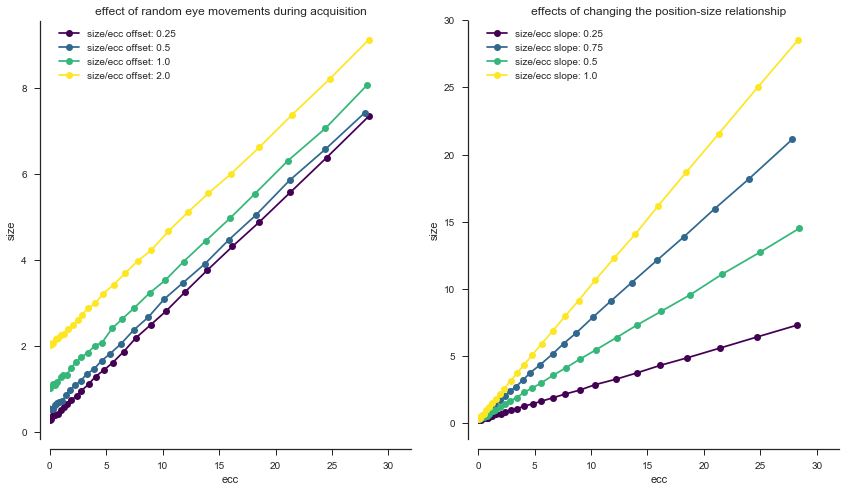

In [231]:
size_offsets = [0.25,0.5,1.0,2.0] 
col = pl.cm.viridis(np.linspace(0,1,len(size_offsets)))

f = pl.figure(figsize=(12,7))
s = f.add_subplot(121)
s.set_ylabel('size')
s.set_xlabel('ecc')
s.set_title('effect of random eye movements during acquisition')
for i, so in enumerate(size_offsets):
    mean_df = neurons_to_voxels(create_neurons(neuron_ecc_size_int=so), 
                                voxel_size=voxel_size, binning_column='mm_from_fovea')
    pl.plot(mean_df['ecc'], mean_df['size'], c = col[i], marker = 'o', label = 'size/ecc offset: ' + str(so))
s.set_xlim([0,32])
pl.legend()

sn.despine(offset=10)

slope_offsets = [0.25,0.75,0.5,1.0] 

# f = pl.figure(figsize=(9,9))
s = f.add_subplot(122)
s.set_ylabel('size')
s.set_xlabel('ecc')
s.set_title('effects of changing the position-size relationship')
for i, so in enumerate(slope_offsets):
    mean_df = neurons_to_voxels(create_neurons(neuron_ecc_size_slope=so), 
                                voxel_size=voxel_size, binning_column='mm_from_fovea')
    pl.plot(mean_df['ecc'], mean_df['size'], c = col[i], marker = 'o', label = 'size/ecc slope: ' + str(so))
s.set_xlim([0,32])
pl.legend()
sn.despine(offset=10)
pl.tight_layout()
pl.savefig('figs/eccen-sizes.pdf')

#### We can also add noise, to the locations and sizes and both, through the sampling on the surface.

/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


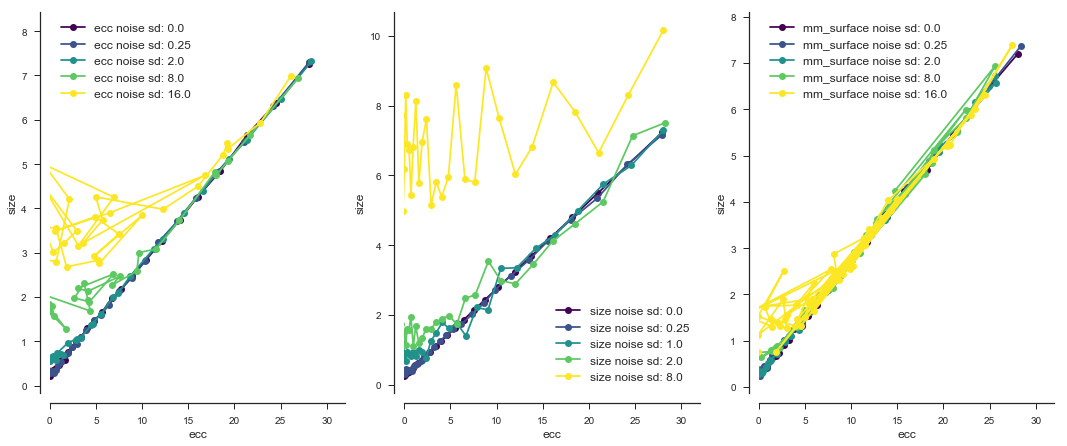

In [232]:
# plotting pars
fs = 12
leg_loc = 1

ecc_sds = [0.0, 0.25, 2.0, 8.0, 16.0] 
col = pl.cm.viridis(np.linspace(0,1,len(ecc_sds)))

f = pl.figure(figsize=(18,7))
s = f.add_subplot(131)
s.set_ylabel('size', fontsize=fs)
s.set_xlabel('ecc', fontsize=fs)
for i, sd in enumerate(ecc_sds):
    mean_df = neurons_to_voxels(create_neurons(neuron_ecc_sd=sd), 
                                voxel_size=voxel_size, binning_column='mm_from_fovea')
    pl.plot(mean_df['ecc'], mean_df['size'], c = col[i], marker = 'o', label = 'ecc noise sd: ' + str(sd))
s.set_xlim([0,32])
pl.legend(fontsize=fs)
sn.despine(offset=10)

size_sds = [0.0, 0.25, 1.0, 2.0, 8.0]

# f = pl.figure(figsize=(9,9))
s = f.add_subplot(132)
s.set_ylabel('size', fontsize=fs)
s.set_xlabel('ecc', fontsize=fs)
for i, sd in enumerate(size_sds):
    mean_df = neurons_to_voxels(create_neurons(neuron_ecc_sd=0, neuron_size_sd=sd), 
                                voxel_size=voxel_size, binning_column='mm_from_fovea')
    pl.plot(mean_df['ecc'], mean_df['size'], c = col[i], marker = 'o', label = 'size noise sd: ' + str(sd))
s.set_xlim([0,32])
pl.legend(fontsize=fs)
sn.despine(offset=10)

mm_sds = [0.0, 0.25, 2.0, 8.0, 16.0]

# f = pl.figure(figsize=(9,9))
s = f.add_subplot(133)
s.set_ylabel('size', fontsize=fs)
s.set_xlabel('ecc', fontsize=fs)
for i, sd in enumerate(mm_sds):
    mean_df = neurons_to_voxels(create_neurons(neuron_size_sd=0.25, neuron_mm_from_fovea_sd=sd), 
                                voxel_size=voxel_size, binning_column='mm_from_fovea')
    pl.plot(mean_df['ecc'], mean_df['size'], c = col[i], marker = 'o', label = 'mm_surface noise sd: ' + str(sd))
s.set_xlim([0,32])
pl.legend(fontsize=fs)
sn.despine(offset=10)

#### Then, we can simulate a stimulus that progressively activates specific visual pathways that are both represented in a given voxel, for example parvocellular vs. magnocellular.

/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


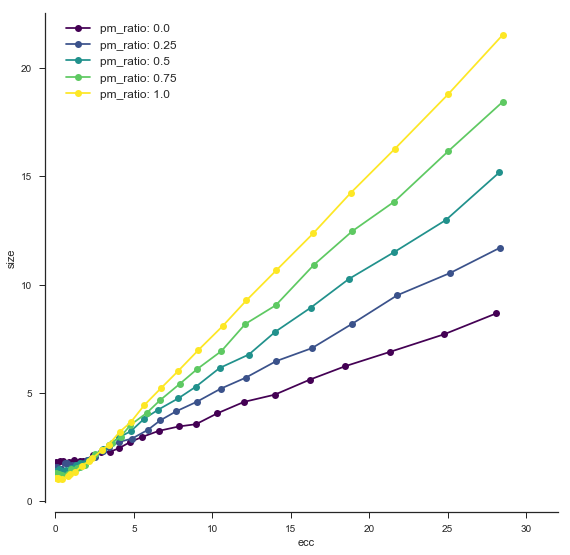

In [233]:
pm_ratios = [0.0, 0.25, 0.5, 0.75, 1.0] 
col = pl.cm.viridis(np.linspace(0,1,len(pm_ratios)))
nr_neurons = 1e4
p_slope, m_slope = 0.75, 0.25
p_int, m_int = 0.125, 1.5

f = pl.figure(figsize=(9,9))
s = f.add_subplot(111)
s.set_ylabel('size')
s.set_xlabel('ecc')
for i, pmr in enumerate(pm_ratios):
    
    p_neurons = create_neurons(nr_neuronal_rfs=nr_neurons*pmr, 
                                neuron_ecc_size_int=p_int,
                                neuron_ecc_size_slope=p_slope,
                                neuron_ecc_sd=1.0,
                                neuron_size_sd=1.0)
    m_neurons = create_neurons(nr_neuronal_rfs=nr_neurons*(1-pmr), 
                                neuron_ecc_size_int=m_int,
                                neuron_ecc_size_slope=m_slope,
                                neuron_ecc_sd=1.0,
                                neuron_size_sd=1.0)   
    
    neurons = pd.concat([p_neurons, m_neurons])
    
    mean_df = neurons_to_voxels(neurons, 
                                voxel_size=voxel_size, binning_column='mm_from_fovea')
    pl.plot(mean_df['ecc'], mean_df['size'], c = col[i], marker = 'o', label = 'pm_ratio: ' + str(pmr))
s.set_xlim([0,32])
pl.legend(fontsize=fs)
sn.despine(offset=10)

#### First forays into attention field interactions, i.e. $g_{cognition}$

/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


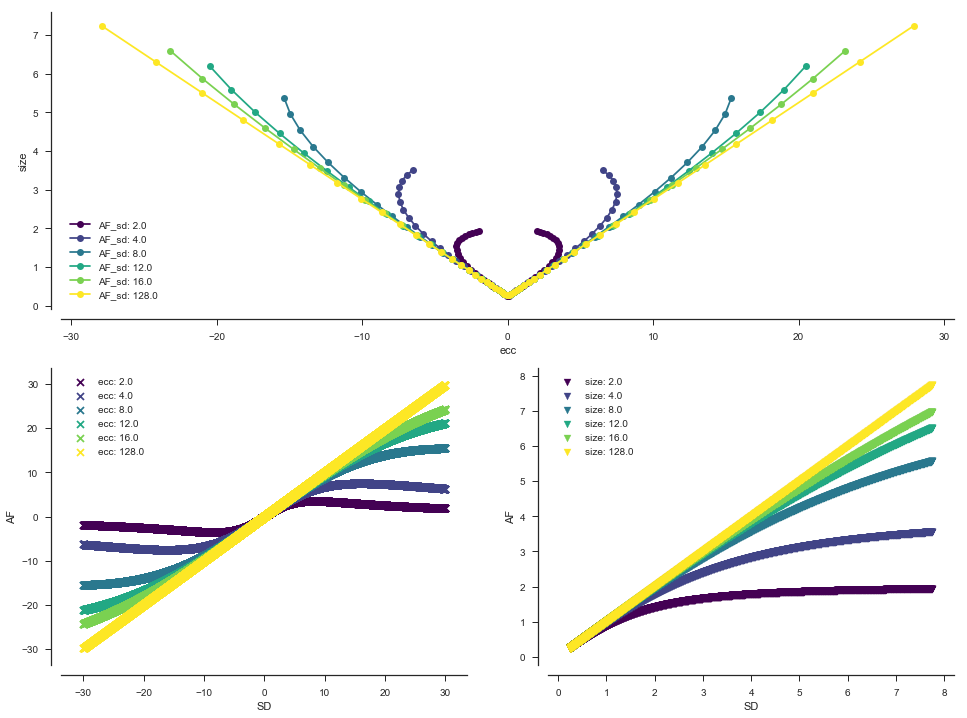

In [234]:
#############################################
# Vary attention field width
#############################################

AF_sds = [2.0, 4.0, 8.0, 12.0, 16.0, 128.0] 
col = pl.cm.viridis(np.linspace(0,1,len(AF_sds)))
nr_neurons = 1e4

f = pl.figure(figsize=(16,12))
s = f.add_subplot(211)
s.set_ylabel('size')
s.set_xlabel('ecc')
s2 = f.add_subplot(223)
s2.set_xlabel('SD')
s2.set_ylabel('AF')
s3 = f.add_subplot(224)
s3.set_xlabel('SD')
s3.set_ylabel('AF')
for i, afs in enumerate(AF_sds):
    
    neurons = create_neurons(nr_neuronal_rfs=nr_neurons*pmr, 
                                neuron_ecc_size_int=0.25,
                                neuron_ecc_size_slope=0.25,
                                neuron_ecc_sd=0.0,
                                neuron_size_sd=0.0,
                                neuron_mm_from_fovea_sd=0.0)

    gauss_AF_neurons(neurons, ecc_AF=0.0, size_AF=afs)
    
    mean_df = neurons_to_voxels(neurons, 
                                voxel_size=voxel_size, binning_column='mm_from_fovea')
    s.plot(mean_df['ecc_AF'], mean_df['size_AF'], c = col[i], marker = 'o', label = 'AF_sd: ' + str(afs))
    
    s2.scatter(neurons['ecc'], neurons['ecc_AF'], color=col[i], marker='x', label = 'ecc: ' + str(afs) )
    s3.scatter(neurons['size'], neurons['size_AF'], color=col[i], marker='v', label = 'size: ' + str(afs) )

s.legend()
s2.legend()
s3.legend()

sn.despine(offset=10)

/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


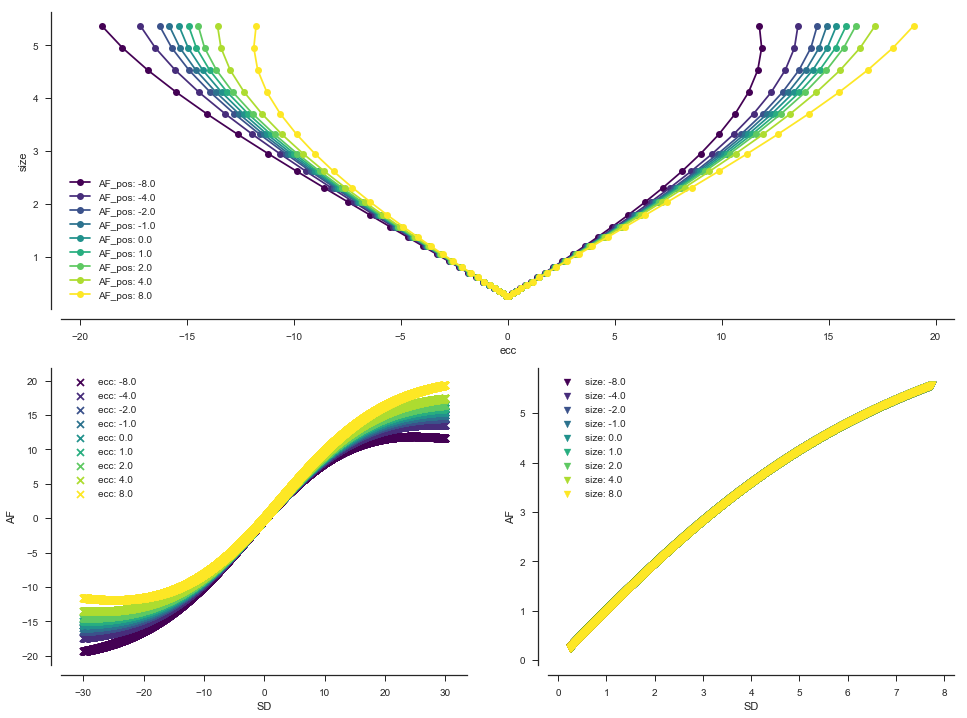

In [235]:
#############################################
# Vary attention field position
#############################################

AF_pos = [-8.0, -4.0, -2.0, -1.0, 0.0, 1.0, 2.0, 4.0, 8.0] 
col = pl.cm.viridis(np.linspace(0,1,len(AF_pos)))

f = pl.figure(figsize=(16,12))
s = f.add_subplot(211)
s.set_ylabel('size')
s.set_xlabel('ecc')
s2 = f.add_subplot(223)
s2.set_xlabel('SD')
s2.set_ylabel('AF')
s3 = f.add_subplot(224)
s3.set_xlabel('SD')
s3.set_ylabel('AF')
for i, afp in enumerate(AF_pos):
    
    neurons = create_neurons(nr_neuronal_rfs=nr_neurons*pmr, 
                                neuron_ecc_size_int=0.25,
                                neuron_ecc_size_slope=0.25,
                                neuron_ecc_sd=0.0,
                                neuron_size_sd=0.0,
                                neuron_mm_from_fovea_sd=0.0)

    gauss_AF_neurons(neurons, ecc_AF=afp, size_AF=8.0)
    
    mean_df = neurons_to_voxels(neurons, 
                                voxel_size=voxel_size, binning_column='mm_from_fovea')
    s.plot(mean_df['ecc_AF'], mean_df['size_AF'], c = col[i], marker = 'o', label = 'AF_pos: ' + str(afp))
    
    s2.scatter(neurons['ecc'], neurons['ecc_AF'], color=col[i], marker='x', label = 'ecc: ' + str(afp) )
    s3.scatter(neurons['size'], neurons['size_AF'], color=col[i], marker='v', label = 'size: ' + str(afp) )

s.legend()
s2.legend()
s3.legend()

sn.despine(offset=10)

### Figure to explain gain-field interactions

/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


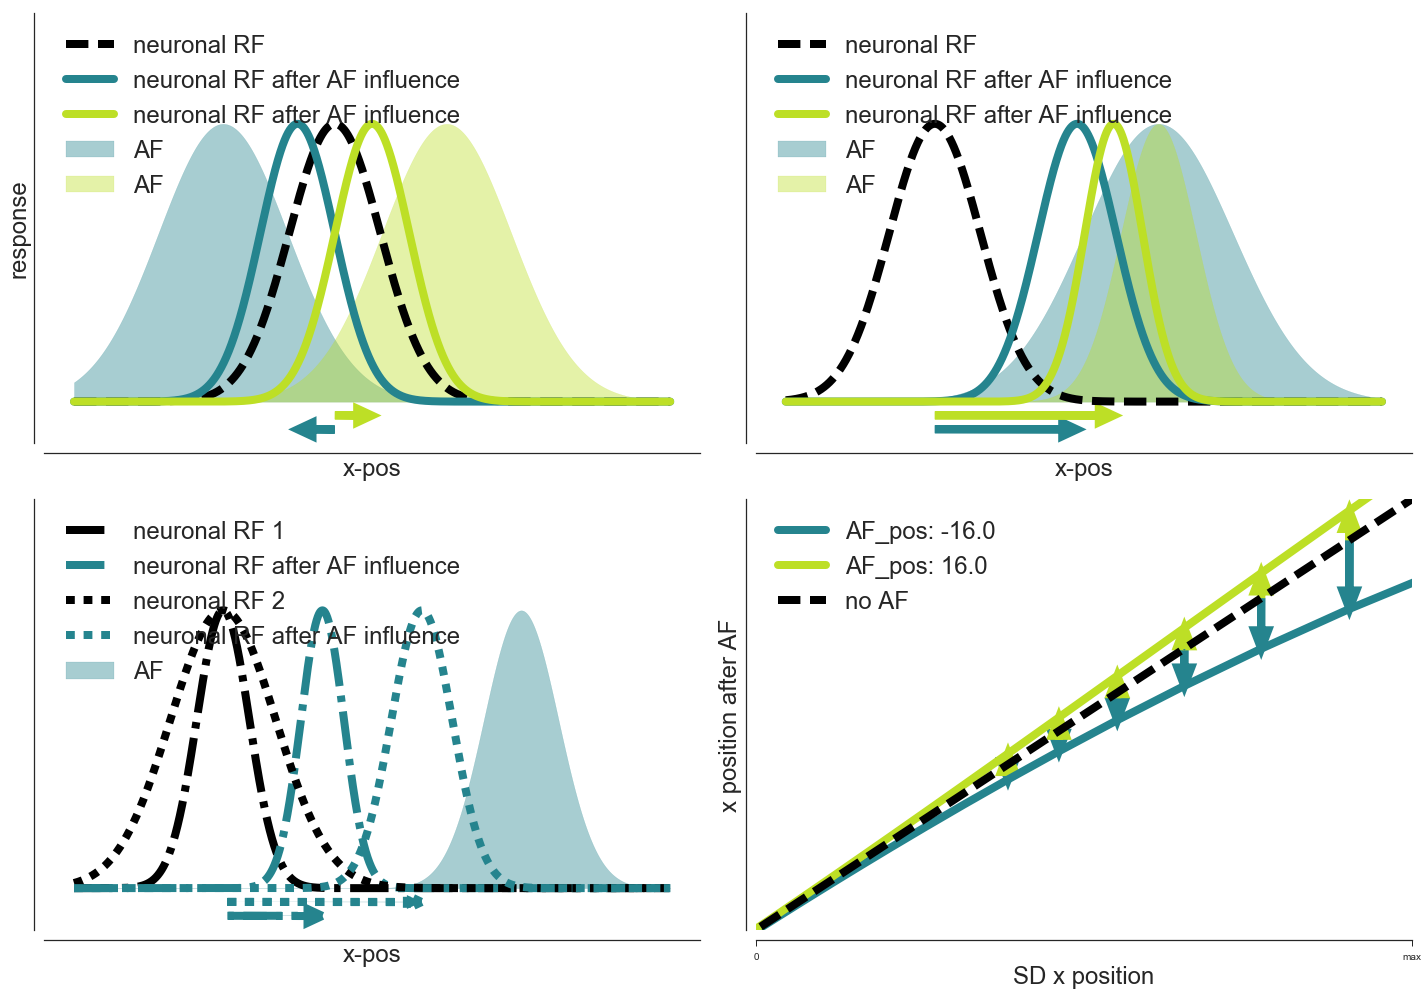

In [375]:
x = np.linspace(-10,6,10000)
m_RF, m_RF2 = -3, -6
s_RF = 3
# xlim_height = 1.4

rf_SD = gauss_rf(x, m_RF, s_RF)

m_AF1, m_AF2 = 0, 0
s_AF1, s_AF2 = 6, 8


# plotting stuff
y_lims = [-0.15, 1.4]
fs = 24
leg_loc = 2
lw = 8.0
ls = ['-.', ':']


AF_pos = [-6.0, 0.0] 
AF_width = [8.0, 2.0] 
col = pl.cm.viridis(np.linspace(0.45,0.9,len(AF_pos)))


f = pl.figure(figsize=(20,14))

s = f.add_subplot(221)
s.set_xlabel('x-pos', fontsize=fs)
s.set_ylabel('response', fontsize=fs)

pl.plot(x, rf_SD, c='k', ls='--', lw=lw, label='neuronal RF')

for i, afp in enumerate(AF_pos):
    af = gauss_rf(x, afp, s_AF1)
    pl.fill_between(x, af, np.zeros(af.shape), color=col[i], label='AF', alpha=0.4)
    pl.plot(x, (rf_SD * af)/np.max(rf_SD * af),  c=col[i], ls='-', lw=lw, label='neuronal RF after AF influence')
    
    max_pos = x[np.argmax((rf_SD * af)/np.max(rf_SD * af))]
    pl.arrow(m_RF, -0.1 + i*0.05, max_pos-m_RF, 0, 
             color=col[i], head_width=0.05, head_length=0.4, lw=lw, 
             overhang=0, capstyle='round', length_includes_head=True)
s.set_xticks([])
s.set_yticks([])
s.set_ylim(y_lims)

s.legend(loc=leg_loc, fontsize=fs)

s = f.add_subplot(222)
s.set_xlabel('x-pos', fontsize=fs)
# s.set_ylabel('response', fontsize=fs)


pl.plot(x, gauss_rf(x, m_RF2, s_RF), c='k', ls='--', lw=lw, label='neuronal RF')

for i, afs in enumerate(AF_width):
    af = gauss_rf(x, m_AF2, afs)
    pl.fill_between(x, af, np.zeros(af.shape), color=col[i], label='AF', alpha=0.4)
    pl.plot(x, (rf_SD * af)/np.max(rf_SD * af), c=col[i], ls='-', lw=lw, label='neuronal RF after AF influence')

    max_pos = x[np.argmax((rf_SD * af)/np.max(rf_SD * af))]
    pl.arrow(m_RF2, -0.1 + i*0.05, max_pos-m_RF2, 0, 
             color=col[i], head_width=0.05, head_length=0.4, lw=lw, 
             overhang=0, capstyle='round', length_includes_head=True)
s.set_xticks([])
s.set_yticks([])
s.set_ylim(y_lims)

s.legend(loc=leg_loc, fontsize=fs)

AF_pos = [-16.0, 16.0] 


s = f.add_subplot(223)
s.set_xlabel('x-pos', fontsize=fs)
# s.set_ylabel('response', fontsize=fs)


rfps = [[-6, 1],[-6, 4]]

af = gauss_rf(x, 2, afs)

for i, (rfp, rfs) in enumerate(rfps):
    
    rf = gauss_rf(x, rfp, rfs)
    pl.plot(x, rf, c='k', ls=ls[i], lw=lw, label='neuronal RF %s'%str(i+1))
    
    pl.plot(x, (rf * af)/np.max(rf * af), c=col[0], ls=ls[i], lw=lw, label='neuronal RF after AF influence')

    max_pos = x[np.argmax((rf * af)/np.max(rf * af))]
    pl.arrow(rfp, -0.1 + i*0.05, max_pos-rfp, 0, 
             color=col[0], head_width=0.05, head_length=0.4, lw=lw, 
             overhang=0, capstyle='butt', length_includes_head=True, ls=ls[i])

pl.fill_between(x, af, np.zeros(af.shape), color=col[0], label='AF', alpha=0.4)

s.set_xticks([])
s.set_yticks([])
s.set_ylim(y_lims)

s.legend(loc=leg_loc, fontsize=fs)

AF_pos = [-16.0, 16.0] 



s = f.add_subplot(224)
s.set_ylabel('x position after AF', fontsize=fs)
s.set_xlabel('SD x position', fontsize=fs)
for i, afp in enumerate(AF_pos):
    
    neurons = create_neurons(nr_neuronal_rfs=nr_neurons, 
                                neuron_ecc_size_int=0.25,
                                neuron_ecc_size_slope=0.25,
                                neuron_ecc_sd=0.0,
                                neuron_size_sd=0.0,
                                neuron_mm_from_fovea_sd=0.0)

    gauss_AF_neurons(neurons, ecc_AF=afp, size_AF=8.0)
    
    mean_df = neurons_to_voxels(neurons, 
                                voxel_size=voxel_size, binning_column='mm_from_fovea')

    ecc = np.zeros((len(mean_df), 4))
    for j, mm in enumerate(mean_df.mm_from_fovea):
        ecc[j,0] = mm
        ecc[j,1] = float(mean_df.iloc[j].ecc)
        ecc[j,2] = float(mean_df.iloc[j].ecc_AF)
        ecc[j,3] = float(mean_df.iloc[j].size_AF) - float(mean_df.iloc[-(j+1)].size_AF)
    ecc = ecc[ecc[:,0] > 0]
    s.plot(mean_df['ecc'], mean_df['ecc_AF'], c = col[i], marker = '|', label = 'AF_pos: ' + str(afp), lw=lw)
    
    for index, mdf in mean_df.iterrows():
        if index > (3*len(mean_df)/4.5):
            pl.arrow(mdf['ecc'], mdf['ecc'], 0, -mdf['ecc']+mdf['ecc_AF'], 
                 color=col[i], head_width=0.15, head_length=0.3, lw=lw, 
                 overhang=0, capstyle='round', length_includes_head=True)

    if i == 1:
        s.plot(mean_df['ecc'], mean_df['ecc'], 'k--', label='no AF', lw=lw)

#     s.plot(ecc[:,1], ecc[:,2], c = col[i], marker = 'o', label = 'AF_pos: ' + str(afp))

s.set_xlim([0,7])
s.set_ylim([0,7])
s.set_xticks([0,7])
s.set_xticklabels(['0','max'])

s.set_yticks([])
s.legend(loc=0, fontsize=fs)
sn.despine(offset=10)

pl.tight_layout()
pl.savefig('figs/gainfield_effects.pdf')

# plot pRF shapes

In [277]:
def gauss_rf_2d(x, y, x0=0, y0=0, s=1, theta=0, ar=1):
    xr = (x-x0) * np.cos(theta) + (y-y0) * np.sin(theta)
    yr = -(x-x0) * np.sin(theta) + (y-y0) * np.cos(theta)
    return np.exp(-(xr**2 + ar**2 * yr**2)/(2*s**2))

def gabor_rf_2d(x, y, x0=0, y0=0, s=1, theta=0, ar=1, sf=0, phi=0):
    xr = (x-x0) * np.cos(theta) + (y-y0) * np.sin(theta)
    yr = -(x-x0) * np.sin(theta) + (y-y0) * np.cos(theta)
    return np.exp(-(xr**2 + ar**2 * yr**2)/(2*s**2)) * np.cos(2*np.pi*xr/sf + phi)

In [358]:
# Our 2-dimensional distribution will be over variables X and Y
N = 75
X = np.linspace(-7.5, 7.5, N)
Y = np.linspace(-7.5, 7.5, N)
X, Y = np.meshgrid(X, Y)

inits = 38, -54

fs = 20
####################################################
x0, y0, s, theta, ar = 0, 0, 1.75, 0, 1


vmin = -0.25
n_levels = 20
css_n = 0.25

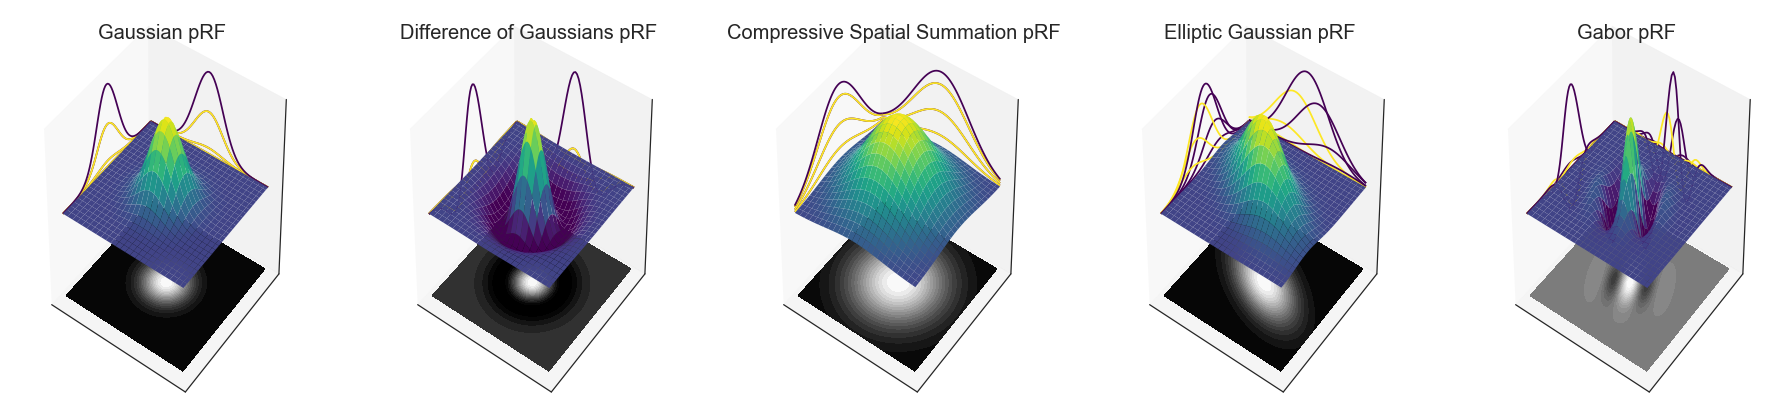

In [359]:

####################################################
Z = gauss_rf_2d(X, Y, x0=x0, y0=y0, s=s, theta=theta, ar=ar)


# Create a surface plot and projected filled contour plot under it.
fig = pl.figure(figsize=(25,6))
ax = fig.add_subplot(151, projection='3d')

cset = ax.contourf(X, Y, Z, zdir='z', offset=-1.05,
                vmax=1., vmin=-0., cmap='gray', alpha=1, levels=np.linspace(np.min(Z), np.max(Z), n_levels))
cset = ax.contour(X, Y, Z, zdir='x', offset=-7.5,
                vmax=1., vmin=-0., cmap=cm.viridis)
cset = ax.contour(X, Y, Z, zdir='y', offset=7.5,
                vmax=1., vmin=-0., cmap=cm.viridis)
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                vmax=1., vmin=vmin, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-1.1,1)
# ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(inits[0], inits[1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([]);
ax.set_title('Gaussian pRF', fontsize=fs)

####################################################
Z_pos = 5 * gauss_rf_2d(X, Y, x0=x0, y0=y0, s=s, theta=theta, ar=ar)
Z_neg = -4 * gauss_rf_2d(X, Y, x0=x0, y0=y0, s=s*1.2, theta=theta, ar=ar)
Z = Z_pos + Z_neg
# Z_range = Z.max()# - Z.min()
# Z -= Z.min()
# Z /= Z_range


ax = fig.add_subplot(152, projection='3d')
# ax = fig.gca(projection='3d')

cset = ax.contourf(X, Y, Z, zdir='z', offset=-1.05,
                vmax=1., vmin=-0.25, cmap='gray', alpha=1, levels=np.linspace(np.min(Z), np.max(Z), n_levels))
cset = ax.contour(X, Y, Z, zdir='x', offset=-7.5,
                vmax=1., vmin=0, cmap=cm.viridis)
cset = ax.contour(X, Y, Z, zdir='y', offset=7.5,
                vmax=1., vmin=0, cmap=cm.viridis)
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                vmax=1., vmin=vmin, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-1.1,1)
# ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(inits[0], inits[1])

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([]);
ax.set_title('Difference of Gaussians pRF', fontsize=fs)

####################################################
Z = gauss_rf_2d(X, Y, x0=x0, y0=y0, s=s, theta=theta, ar=ar)
Z **= css_n

# Create a surface plot and projected filled contour plot under it.
ax = fig.add_subplot(153, projection='3d')

cset = ax.contourf(X, Y, Z, zdir='z', offset=-1.05,
                vmax=1., vmin=-0., cmap='gray', alpha=1, levels=np.linspace(np.min(Z), np.max(Z), n_levels))
cset = ax.contour(X, Y, Z, zdir='x', offset=-7.5,
                vmax=1., vmin=-0., cmap=cm.viridis)
cset = ax.contour(X, Y, Z, zdir='y', offset=7.5,
                vmax=1., vmin=-0., cmap=cm.viridis)
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                vmax=1., vmin=vmin, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-1.1,1)
# ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(inits[0], inits[1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([]);
ax.set_title('Compressive Spatial Summation pRF', fontsize=fs)


####################################################
Z = gauss_rf_2d(X, Y, x0=x0, y0=y0, s=s*2, theta=-np.pi/6, ar=2)

ax = fig.add_subplot(154, projection='3d')
# ax = fig.gca(projection='3d')

cset = ax.contourf(X, Y, Z, zdir='z', offset=-1.05,
                vmax=1., vmin=-0., cmap='gray', alpha=1, levels=np.linspace(np.min(Z), np.max(Z), n_levels))
cset = ax.contour(X, Y, Z, zdir='x', offset=-7.5,
                vmax=1., vmin=-0., cmap=cm.viridis)
cset = ax.contour(X, Y, Z, zdir='y', offset=7.5,
                vmax=1., vmin=-0., cmap=cm.viridis)
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                vmax=1., vmin=vmin, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-1.1,1)
# ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(inits[0], inits[1])

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([]);
ax.set_title('Elliptic Gaussian pRF', fontsize=fs)


####################################################
Z = gabor_rf_2d(X, Y, x0=x0, y0=y0, s=s, theta=np.pi/8, ar=ar, sf=4, phi=0)
# Z_neg = -0.5 * gauss_rf_2d(X, Y, x0=x0, y0=y0, s=s*2, theta=theta, ar=ar)
# Z = Z_pos + Z_neg

ax = fig.add_subplot(155, projection='3d')

cset = ax.contourf(X, Y, Z, zdir='z', offset=-1.05,
                vmax=1., vmin=-1., cmap='gray', alpha=1, levels=np.linspace(np.min(Z), np.max(Z), n_levels))
cset = ax.contour(X, Y, Z, zdir='x', offset=-7.5,
                vmax=1., vmin=-0., cmap=cm.viridis)
cset = ax.contour(X, Y, Z, zdir='y', offset=7.5,
                vmax=1., vmin=-0., cmap=cm.viridis)
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                vmax=1., vmin=vmin, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-1.1,1)
# ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(inits[0], inits[1])

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([]);
ax.set_title('Gabor pRF', fontsize=fs)


pl.tight_layout()
pl.savefig('figs/example_prfs.pdf')

**Gaussian: **

$$ r(x, y; \mu, \alpha, \sigma) = \alpha e^{-\frac{(\mu_{x}-x)^{2} + (\mu_{y}-y)^{2}}{\sigma^2}}$$

**Difference of Gaussians: **

$$ r(x, y; \mu, \alpha_{pos}, \alpha_{neg}, \sigma_{pos}, \sigma_{neg}) = \alpha_{pos} e^{-\frac{(\mu_{x}-x)^{2} + (\mu_{y}-y)^{2}}{\sigma_{pos}^2}} - \alpha_{neg} e^{-\frac{(\mu_{x}-x)^{2} + (\mu_{y}-y)^{2}}{\sigma_{neg}^2}}$$

**Compressive Spatial Summation: **

$$ r(x, y;\alpha, \mu, \sigma, n) = \alpha e^{-n \frac{(\mu_{x}-x)^{2} + (\mu_{y}-y)^{2}}{\sigma^2}}$$

**Elliptic Gaussian: **

$$ r(x \in \mathbb{R}^2; \alpha, \mu, \Sigma \in \mathbb{R}^{2x2}) = \alpha e^{-\frac{1}{2}(x-\mu)^{T} \Sigma^{-1} (x-\mu)}$$

**Gabor wavelet (real): **

$$g(x,y;\lambda,\theta,\phi,\gamma) = \alpha e^{-\frac{x'^2+\gamma^2 y'^2}{2\sigma^2}} cos\bigg(2\pi\frac{x'}{\lambda} + \phi\bigg)$$
Where
$$  x' = x \cdot cos\theta + y \cdot sin\theta $$
$$  y' = -x \cdot sin\theta + y \cdot cos\theta $$



In [14]:
def cm(ecc, mm_0, tau):
    return mm_0 * np.exp(-ecc*tau)
    

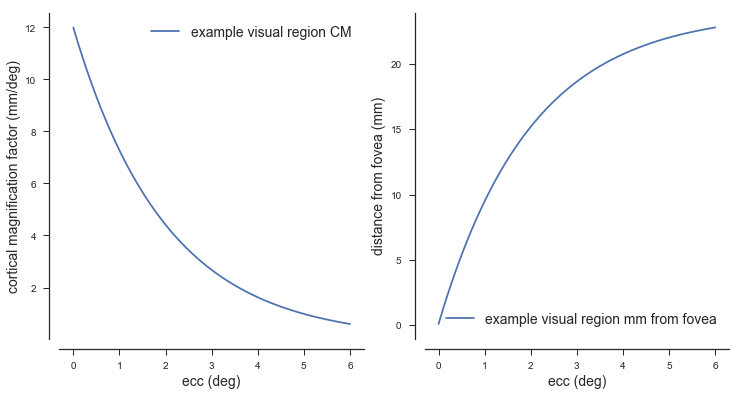

In [32]:
ecc_max = 6
ecc_nr = 1000
ecc_range = np.linspace(0,ecc_max,ecc_nr)
mm_0 = 12
tau = 0.5
fs = 14

cm_trace = cm(ecc_range, mm_0, tau)

f = pl.figure(figsize=(12,6))
s = f.add_subplot(121)
pl.plot(ecc_range, cm_trace, label='example visual region CM')
s.legend(loc=0, fontsize=fs)
s.set_xlabel('ecc (deg)', fontsize=fs)
s.set_ylabel('cortical magnification factor (mm/deg)', fontsize=fs)
sn.despine(offset=10)

s = f.add_subplot(122)
mm_cortex_from_fovea = np.cumsum(cm_trace) / (ecc_nr/ecc_max)
pl.plot(ecc_range, mm_cortex_from_fovea, label='example visual region mm from fovea')
s.legend(loc=0, fontsize=fs)
s.set_xlabel('ecc (deg)', fontsize=fs)
s.set_ylabel('distance from fovea (mm)', fontsize=fs)
sn.despine(offset=10)



In [10]:
np.exp(0)

1.0